In [1]:
import logging
import sys

import torch


LOGGER = logging.getLogger('detector')
LOGGER.setLevel(logging.INFO)


stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setLevel(logging.INFO)


LOGGER.addHandler(stream_handler)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOGGER.info(f'device is {DEVICE}')

device is cpu


In [2]:
import torch.nn as nn
import torch.nn.functional as F



class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock."""

    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.ind = None

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, "shortcut") else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        if self.ind is not None:
            out += shortcut[:, self.ind, :, :]
        else:
            out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            BLOCK = block(self.in_planes, planes, stride)
            layers.append(BLOCK)
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(num_classes=10):
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes)

In [3]:
import glob
import os


ROOT_DIR = 'eval_dataset'

def load_model(num_classes, model_path):
    model = PreActResNet18(num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.to(DEVICE)
    model.eval()

    return model


def load_test(idx: int):
    test_root_dir = os.path.join(ROOT_DIR, str(idx))

    metadata = torch.load(os.path.join(test_root_dir, 'metadata.pt'))

    num_classes = metadata['num_classes']
    ground_truth = metadata['ground_truth']
    images_root_dir = metadata['test_images_folder_address']
    transformation = metadata['transformation']

    model_path = os.path.join(test_root_dir, 'model.pt')

    if images_root_dir[0] == '.':
        images_root_dir = images_root_dir[2:]

    images_root_dir = os.path.join(test_root_dir, images_root_dir)


    model = load_model(num_classes, model_path)

    return model, num_classes, ground_truth, transformation, images_root_dir


In [4]:
model, num_classes, ground_truth, transformation, images_root_dir = load_test(0)

In [5]:
model

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

In [6]:
from typing import List, Tuple

from torchvision import transforms
from PIL import Image


def transform_images(images_path: List[str], transformation: transforms.Compose):
    transformed_images = []
    for img_path in images_path:
        try:
            image = Image.open(img_path).convert('RGB')
            image = transformation(image)
            transformed_images.append(image)
        except Exception as e:
            LOGGER.error(f"Error loading image {img_path}: {e}")

    if not transformed_images:
        LOGGER.error("No images were loaded. Please check the images_path list.")

    return torch.stack(transformed_images).to(DEVICE)



In [7]:

def extract_normalization_params(transformation: transforms.Compose):
    mean = None
    std = None

    for transform in transformation.transforms:
        if isinstance(transform, transforms.Normalize):
            mean = transform.mean
            std = transform.std
    return mean, std


def get_logits_and_probs(model: PreActResNet, transformed_images: torch.Tensor):
    logits = model(transformed_images)
    probabilities = F.softmax(logits, dim=1)
    return probabilities, logits


In [8]:
from collections import defaultdict

def calculate_margins(probs: List[torch.Tensor],
                      labels: List[int]) -> Tuple[defaultdict[int, List[float]],
                                                           defaultdict[int, List[float]]]:
    accepted_margins = defaultdict(list)
    failed_margins = defaultdict(list)
    for i in range(len(probs)):
        topk = torch.topk(probs[i], k=2, largest=True, sorted=True)
        topk_values = topk.values

        margin = topk_values[0].item() - topk_values[1].item()
        if labels[i] == torch.argmax(probs[i]).item():
            accepted_margins[labels[i]].append(margin)
        else:
            failed_margins[torch.argmax(probs[i]).item()].append(margin)
    return accepted_margins, failed_margins

def find_safe_margin(accepted_margins: defaultdict[int, List[float]],
                     failed_margins: defaultdict[int, List[float]]):
    min_accepted_margins = dict()
    for c in accepted_margins.keys():
        max_failed = float('inf')
        if failed_margins[c]:
            max_failed = max(failed_margins[c])

        min_accepted_margin = max_failed
        for margin in accepted_margins[c]:
            if margin <= min_accepted_margin:
                min_accepted_margin = margin

        min_accepted_margins[c] = min_accepted_margin
    return min_accepted_margins


In [9]:
def project_image(optimized_img: torch.Tensor, mean: float, std: float):
    mean = torch.tensor(mean).view(-1, 1, 1).to(optimized_img.device)
    std = torch.tensor(std).view(-1, 1, 1).to(optimized_img.device)

    min_val = (0.0 - mean) / std
    max_val = (1.0 - mean) / std

    optimized_img = torch.clamp(optimized_img, min=min_val, max=max_val)

    return optimized_img


In [10]:

def select_top_images_per_class(probs: List[torch.Tensor],
                                images: List[torch.Tensor],
                                labels: List[int],
                                num_classes: int, top_k=3) -> defaultdict[int, List[torch.Tensor]]:

    selected_images_per_class = defaultdict(list)

    with torch.no_grad():
        for idx, (prob, label) in enumerate(zip(probs, labels)):
            detected_class = torch.argmax(prob).item()
            if detected_class == label:
                confidence = prob[detected_class].item()
                selected_images_per_class[label].append((confidence, images[idx]))

    for c in range(num_classes):
        class_images = selected_images_per_class[c]
        sorted_images = sorted(class_images, key=lambda x: x[0], reverse=True)
        selected_images_per_class[c] = [img for _, img in sorted_images[:top_k]]
    return selected_images_per_class




In [11]:
def generate_random_image(transformation):
    transformation = transforms.Compose([transforms.ToPILImage()] + list(transformation.transforms))
    return transformation(torch.randn(3, *(220, 220)) * 255)


In [12]:
import random

def compute_max_margin(model: PreActResNet,
                       selected_images_per_class: dict[int, List],
                       num_classes: int,
                       projection_mean: float, projection_std: float,
                       max_iterations=1000, lr=0.01, tolerance=1e-5, max_img_per_class=3):
    model.eval()
    max_margins = {}
    all_margins_per_class = defaultdict(list)
    all_triggers_per_class = defaultdict(list)

    for c in range(num_classes):
        margins = []
        triggers = []

        LOGGER.info(f"\nProcessing Class {c}/{num_classes - 1}")
        images_to_optimize = []
        for k in range(num_classes):
            if k == c:
                continue
            images = selected_images_per_class.get(k, [])
            if not images:
                continue
            images_to_optimize.extend(images)
        random.shuffle(images_to_optimize)
        images_to_optimize = images_to_optimize[:max_img_per_class]

        LOGGER.info(f"  Total images to optimize for class {c}: {len(images_to_optimize)}")

        for idx, img in enumerate(images_to_optimize):
            max_margin = -float('inf')
            trigger = None

            optimized_img = img.clone().detach().to(DEVICE)
            optimized_img.requires_grad = True

            optimizer = torch.optim.Adam([optimized_img], lr=lr)

            f_old = None

            for iteration in range(max_iterations):
                optimizer.zero_grad()
                probs, logits = get_logits_and_probs(model, optimized_img.unsqueeze(0))
                logits = logits.squeeze(0)
                g_c = logits[c]

                mask = torch.ones(num_classes, dtype=torch.bool).to(DEVICE)
                mask[c] = False
                g_k = torch.max(logits[mask])

                margin = g_c - g_k
                if margin > max_margin:
                    max_margin = margin
                    trigger = optimized_img.detach().cpu().clone()

                loss = -margin

                loss.backward()

                optimizer.step()

                with torch.no_grad():
                    optimized_img.copy_(project_image(optimized_img, projection_mean, projection_std))

                f_new = margin.item()
                if f_old is not None:
                    relative_change = abs(f_new - f_old) / (abs(f_old) + 1e-8)
                    if relative_change < tolerance:
                        break
                f_old = f_new
            margins.append(max_margin)
            triggers.append(trigger)
            

        if margins:
            all_triggers_per_class[c] = triggers.copy()
            all_margins_per_class[c] = margins.copy()
            max_margins[c] = max(margins)
            LOGGER.info(f"  Maximum Margin for class {c}: {max_margins[c]:.4f}")
        else:
            max_margins[c] = 0.0
            LOGGER.info(f"  No margins computed for class {c}.")

    max_margins = [x[1].item() for x in sorted(max_margins.items(), key=lambda x: x[0])]
    
    return max_margins, all_triggers_per_class, all_margins_per_class



In [13]:
import warnings

import numpy as np
from scipy import stats


def compute_p_values(gamma_list: List[float],
                     distributions=['gamma', 'norm'], p_value_type='standard') -> dict[str, float]:

    if not gamma_list:
        raise ValueError("gamma_list is empty.")

    gamma_array = np.array(gamma_list)
    r_max = np.max(gamma_array)
    n = len(gamma_array)

    null_data = gamma_array[gamma_array != r_max]
    if len(null_data) == 0:
        raise ValueError("All values in gamma_list are identical.")

    p_values = {}

    for dist_name in distributions:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                if dist_name == 'gamma':
                    a, loc, scale = stats.gamma.fit(null_data, floc=0)
                    fitted_dist = stats.gamma(a, loc=loc, scale=scale)
                elif dist_name == 'norm':
                    mu, sigma = stats.norm.fit(null_data)
                    fitted_dist = stats.norm(loc=mu, scale=sigma)
                elif dist_name == 'expon':
                    loc, scale = stats.expon.fit(null_data)
                    fitted_dist = stats.expon(loc=loc, scale=scale)
                elif dist_name == 'beta':
                    a, b, loc, scale = stats.beta.fit(null_data, floc=0, fscale=1)
                    fitted_dist = stats.beta(a, b, loc=loc, scale=scale)
                elif dist_name == 'lognorm':
                    s, loc, scale = stats.lognorm.fit(null_data, floc=0)
                    fitted_dist = stats.lognorm(s, loc=loc, scale=scale)
                else:
                    LOGGER.error(f"Distribution '{dist_name}' is not supported.")
                    continue

                H0_r_max = fitted_dist.cdf(r_max)

                if p_value_type == 'standard':
                    p_val = 1 - H0_r_max**n
                elif p_value_type == 'user_specified':
                    p_val = H0_r_max**(n-1)
                else:
                    LOGGER.error(f"p_value_type '{p_value_type}' is not recognized. Choose 'standard' or 'user_specified'.")
                    continue

                p_values[dist_name] = p_val

        except Exception as e:
            LOGGER.error(f"An error occurred while fitting distribution '{dist_name}': {e}")
            p_values[dist_name] = None

    return p_values


In [14]:
model, num_classes, ground_truth, transformation, images_root_dir = load_test(2)

In [15]:
ground_truth

False

In [16]:
import time

t = time.time()

model = model.to(DEVICE)
model.eval()

images_path = glob.glob(os.path.join(images_root_dir, '*.jpg'))
labels = [int(image_path.split('_')[-1].split('.')[0]) for image_path in images_path]

projection_mean, projection_std = extract_normalization_params(transformation)
transformed_images = transform_images(images_path, transformation)

probs, logits = get_logits_and_probs(model, transformed_images)
accepted_margins, failed_margins = calculate_margins(logits, labels)
safe_margins = [x[1] for x in
                sorted(find_safe_margin(accepted_margins, failed_margins).items(),
                       key=lambda x: x[0])]
confident_images_per_class = select_top_images_per_class(probs, transformed_images,
                                labels, num_classes, top_k=3)
k = 1
#confident_images_per_class = {c: [generate_random_image(transformation) for i in range(k)]
#                              for c in range(num_classes)}

max_margins, triggers_per_class, all_margins_per_class = compute_max_margin(model, confident_images_per_class,
                                   num_classes, projection_mean, projection_std,
                                   max_iterations=500, lr=0.01,
                                   tolerance=1e-5,
                                   max_img_per_class=2)

p_values_standard = compute_p_values(max_margins, distributions=['gamma', 'norm', 'expon'],
                                     p_value_type='standard')
safe_p_values_standard = compute_p_values(safe_margins, distributions=['gamma', 'norm', 'expon'],
                                          p_value_type='standard')

print(round(time.time() - t, 2), ' seconds')


Processing Class 0/9
  Total images to optimize for class 0: 2
  Maximum Margin for class 0: 34.5235

Processing Class 1/9
  Total images to optimize for class 1: 2
  Maximum Margin for class 1: 45.5479

Processing Class 2/9
  Total images to optimize for class 2: 2
  Maximum Margin for class 2: 24.9980

Processing Class 3/9
  Total images to optimize for class 3: 2
  Maximum Margin for class 3: 28.4304

Processing Class 4/9
  Total images to optimize for class 4: 2
  Maximum Margin for class 4: 27.2063

Processing Class 5/9
  Total images to optimize for class 5: 2
  Maximum Margin for class 5: 94.8370

Processing Class 6/9
  Total images to optimize for class 6: 2
  Maximum Margin for class 6: 26.2219

Processing Class 7/9
  Total images to optimize for class 7: 2
  Maximum Margin for class 7: 36.2613

Processing Class 8/9
  Total images to optimize for class 8: 2
  Maximum Margin for class 8: 42.0086

Processing Class 9/9
  Total images to optimize for class 9: 2
  Maximum Margin f

In [17]:
p_values_standard

{'gamma': 1.6538992397840957e-09, 'norm': 0.0, 'expon': 0.002562337471917253}

In [18]:
safe_p_values_standard

{'gamma': 0.3257437515907471,
 'norm': 0.06399811442080117,
 'expon': 0.1445862582538635}

In [21]:
confident_images_per_class = select_top_images_per_class(probs, transformed_images,
                                labels, num_classes, top_k=2)

Plotted image: clean_num_0
Plotted image: clean_num_1


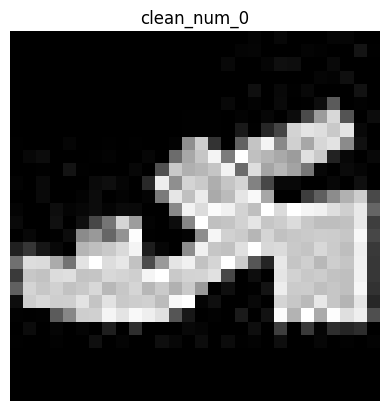

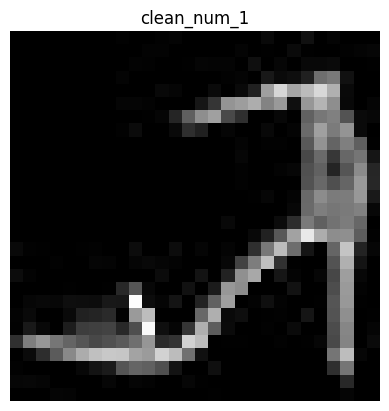

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def imshow(tensor, mean, std, title=None, save_dir=None, filename=None):
    plt.figure()
    img = tensor.clone()
    if img.dim() == 4:
        img = img[0]
    num_channels = img.size(0)
    if isinstance(mean, (list, tuple)):
        if len(mean) == 1:
            mean = [mean[0]] * num_channels
        elif len(mean) != num_channels:
            raise ValueError(f"Length of mean ({len(mean)}) does not match number of channels ({num_channels}).")
        mean = torch.tensor(mean).to(DEVICE)
    else:
        mean = torch.tensor([mean] * num_channels).to(DEVICE)
    if isinstance(std, (list, tuple)):
        if len(std) == 1:
            std = [std[0]] * num_channels
        elif len(std) != num_channels:
            raise ValueError(f"Length of std ({len(std)}) does not match number of channels ({num_channels}).")
        std = torch.tensor(std).to(DEVICE)
    else:
        std = torch.tensor([std] * num_channels).to(DEVICE)
    img = img.to(DEVICE)
    for c in range(num_channels):
        img[c] = img[c] * std[c] + mean[c]
    img = torch.clamp(img, 0, 1)
    np_img = img.cpu().numpy()
    if num_channels == 1:
        np_img = np_img.squeeze(0)
        plt.imshow(np_img, cmap='gray')
    else:
        np_img = np.transpose(np_img, (1, 2, 0))
        plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{filename}.png')
        plt.savefig(save_path, bbox_inches='tight')
        LOGGER.info(f"Saved image plot to {save_path}")
    plt.plot()
    #plt.close()
    LOGGER.info(f"Plotted image: {title}")


for i, img in enumerate(confident_images_per_class[5]):
    imshow(img, projection_mean, projection_std, f'clean_num_{i}')

In [26]:
print(confident_images_per_class[0][0].shape)
triggers_per_class[0][0].shape

torch.Size([3, 28, 28])


torch.Size([3, 28, 28])

MM tensor(94.8370, grad_fn=<SubBackward0>)
Plotted image: adversary_num_0
MM tensor(89.5917, grad_fn=<SubBackward0>)
Plotted image: adversary_num_1


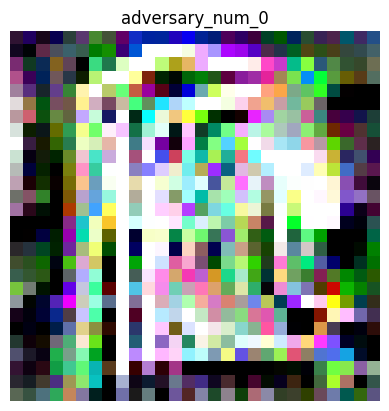

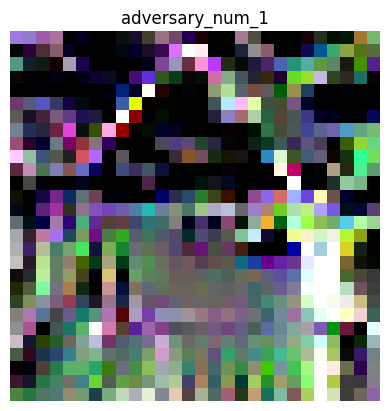

In [27]:
for i, (img, margin) in enumerate(zip(triggers_per_class[5], all_margins_per_class[5])):
    print('MM', margin)
    imshow(img, projection_mean, projection_std, f'adversary_num_{i}')
    

In [35]:
def imshow_ax(ax, tensor, mean, std, title=None):
    img = tensor.clone()
    if img.dim() == 4:
        img = img[0]
    num_channels = img.size(0)
    
    # Handle mean and std
    if isinstance(mean, (list, tuple)):
        if len(mean) == 1:
            mean = [mean[0]] * num_channels
        elif len(mean) != num_channels:
            raise ValueError(f"Length of mean ({len(mean)}) does not match number of channels ({num_channels}).")
        mean = torch.tensor(mean).to(DEVICE)
    else:
        mean = torch.tensor([mean] * num_channels).to(DEVICE)
    
    if isinstance(std, (list, tuple)):
        if len(std) == 1:
            std = [std[0]] * num_channels
        elif len(std) != num_channels:
            raise ValueError(f"Length of std ({len(std)}) does not match number of channels ({num_channels}).")
        std = torch.tensor(std).to(DEVICE)
    else:
        std = torch.tensor([std] * num_channels).to(DEVICE)
    
    img = img.to(DEVICE)
    for c in range(num_channels):
        img[c] = img[c] * std[c] + mean[c]
    img = torch.clamp(img, 0, 1)
    np_img = img.cpu().numpy()
    
    if num_channels == 1:
        np_img = np_img.squeeze(0)
        ax.imshow(np_img, cmap='gray')
    else:
        np_img = np.transpose(np_img, (1, 2, 0))
        ax.imshow(np_img)
    
    if title:
        ax.set_title(title)
    ax.axis('off')

def plot_images_grid(clean_images: List[torch.Tensor],
                     adversarial_images: List[torch.Tensor],
                     projection_mean: List[float],
                     projection_std: List[float],
                     save_path: str,
                     cols: int = 5):
    total_clean = len(clean_images)
    total_adversarial = len(adversarial_images)
    total = total_clean + total_adversarial
    
    # Determine grid size
    rows = (total + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    
    # Plot clean images
    for i, img in enumerate(clean_images):
        title = f'Clean #{i}'
        imshow_ax(axes[i], img, projection_mean, projection_std, title=title)
    
    # Plot adversarial images
    for i, img in enumerate(adversarial_images):
        idx = total_clean + i
        title = f'Adversary #{i}'
        imshow_ax(axes[idx], img, projection_mean, projection_std, title=title)
    
    # Turn off any remaining axes if total < rows*cols
    for i in range(total, rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    LOGGER.info(f"Saved combined image grid to {save_path}")

In [36]:
plot_images_grid(confident_images_per_class[5],
                 triggers_per_class[5], projection_mean, projection_std, 'test.png')

Saved combined image grid to test.png


In [37]:
transformation

Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [32]:
model.named_modules

<bound method Module.named_modules of PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0):

In [46]:
from tqdm import tqdm


def select_neurons_and_get_activations_per_each(model, percent_per_layer, inputs: List[torch.Tensor]):
    LOGGER.info("Selecting neurons and collecting activations")
    activation = defaultdict(list)
    hooks = []
    selected_neurons = {}
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            layers.append(name)
    for name in layers:
        def get_activation(name):
            def hook(model, input, output):
                act = output.detach()
                if act.dim() > 2:
                    act = act.mean(dim=[2,3])
                act = act.squeeze(0).cpu().numpy()
                if act.ndim == 1:
                    activation[name].append(act)
                else:
                    activation[name].append(act.flatten())
            return hook
        hooks.append(model.get_submodule(name).register_forward_hook(get_activation(name)))
    LOGGER.info("Registered hooks")
    model.eval()
    with torch.no_grad():
        for img in tqdm(inputs, desc="Processing inputs"):
            model(img.unsqueeze(0))
    for hook in hooks:
        hook.remove()
    LOGGER.info("Collected activations")
    for name in layers:
        acts = activation[name]
        if len(acts) != len(inputs):
            LOGGER.error(f"Activation length mismatch for layer {name}: expected {len(inputs)}, got {len(acts)}")
            raise ValueError(f"Activation length mismatch for layer {name}")
        act = np.stack(acts, axis=0)
        num_neurons = act.shape[1]
        selected = np.random.choice(num_neurons, max(1, int(num_neurons * percent_per_layer)), replace=False)
        selected_neurons[name] = selected
    LOGGER.info("Selected neurons per layer")
    activations_per_input = []
    for img_idx in tqdm(range(len(inputs)), desc="Aggregating activations"):
        img_activations = []
        for name in layers:
            act = activation[name][img_idx]
            selected = selected_neurons[name]
            img_activations.extend(act[selected])
        activations_per_input.append(img_activations)
    LOGGER.info("Aggregated activations per input")
    return activations_per_input

In [50]:
import seaborn as sns


# ---------------------- Correlation Computation ----------------------

def compute_neuron_pairwise_correlation(activations: List[List[float]]) -> np.ndarray:
    LOGGER.info("Computing neuron pairwise correlation")
    activation_matrix = np.array(activations)  # Shape: (num_inputs, num_neurons)
    if activation_matrix.ndim != 2:
        LOGGER.error("Activation matrix is not 2D")
        raise ValueError("Activation matrix must be 2D")
    corr_matrix = np.corrcoef(activation_matrix, rowvar=False)  # Correlation between neurons
    LOGGER.info("Computed neuron pairwise correlation")
    return corr_matrix

# ---------------------- Plotting Functions ----------------------

def plot_correlation_heatmap(ax, corr_matrix: np.ndarray, title: str, vmin=-1, vmax=1):
    """
    Plots a single correlation heatmap on the given Axes.

    Args:
        ax (matplotlib.axes.Axes): The Axes object to plot the heatmap on.
        corr_matrix (np.ndarray): The correlation matrix to visualize.
        title (str): Title of the heatmap.
        vmin (float, optional): Minimum value for colormap scaling. Defaults to -1.
        vmax (float, optional): Maximum value for colormap scaling. Defaults to 1.
    """
    LOGGER.info(f"Plotting correlation heatmap: {title}")
    sns.heatmap(corr_matrix, cmap='viridis', annot=False, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    LOGGER.info(f"Plotted correlation heatmap: {title}")

def plot_difference_heatmap(ax, corr_diff: np.ndarray, title: str, vmin=-1, vmax=1):
    """
    Plots a difference correlation heatmap on the given Axes.

    Args:
        ax (matplotlib.axes.Axes): The Axes object to plot the heatmap on.
        corr_diff (np.ndarray): The difference between two correlation matrices.
        title (str): Title of the heatmap.
        vmin (float, optional): Minimum value for colormap scaling. Defaults to -1.
        vmax (float, optional): Maximum value for colormap scaling. Defaults to 1.
    """
    LOGGER.info(f"Plotting difference correlation heatmap: {title}")
    sns.heatmap(corr_diff, cmap='bwr', center=0, vmin=vmin, vmax=vmax, annot=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    LOGGER.info(f"Plotted difference correlation heatmap: {title}")

def plot_neuron_pairwise_correlation_heatmaps(axes, activations: List[List[float]], label: str, vmin=-1, vmax=1, save_dir: str = None):
    LOGGER.info(f"Plotting neuron pairwise correlation heatmaps for {label} inputs")
    for idx, ax in enumerate(axes):
        if idx >= len(activations):
            ax.axis('off')
            continue
        act = activations[idx]
        act_array = np.array(act)
        if act_array.size < 2:
            LOGGER.warning(f"Not enough neurons to compute pairwise correlation for {label} Input {idx}")
            ax.axis('off')
            continue
        if np.std(act_array) == 0:
            corr = np.zeros((len(act_array), len(act_array)))
        else:
            corr = np.corrcoef(act_array)
        if corr.size == 1:
            LOGGER.warning(f"Correlation matrix is scalar for {label} Input {idx}, skipping heatmap.")
            ax.axis('off')
            continue
        sns.heatmap(corr, cmap='coolwarm', annot=False, vmin=vmin, vmax=vmax, ax=ax)
        ax.set_title(f'{label} Input {idx}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        if save_dir:
            save_path = os.path.join(save_dir, f'{label.lower()}_input_{idx}_pairwise_correlation_heatmap.png')
            plt.savefig(save_path, bbox_inches='tight')
            LOGGER.info(f"Saved neuron pairwise correlation heatmap to {save_path}")
        LOGGER.info(f"Plotted neuron pairwise correlation heatmap for {label} Input {idx}")
    LOGGER.info(f"Completed plotting neuron pairwise correlation heatmaps for {label} inputs")

# ---------------------- Correlation Analysis and Plotting ----------------------
def calculate_pearson_correlation_and_plot(clean_activations: List[List[float]], anomalous_activations: List[List[float]],
                                          clean_corr, anomalous_corr):
    """
    Calculates Pearson correlations and plots correlation heatmaps for clean and anomalous activations.

    Args:
        clean_activations (List[List[float]]): Activations from clean inputs.
        anomalous_activations (List[List[float]]): Activations from anomalous inputs.
        clean_corr (np.ndarray): Correlation matrix for clean inputs.
        anomalous_corr (np.ndarray): Correlation matrix for anomalous inputs.
    """
    LOGGER.info("Calculating Pearson correlations between clean and anomalous activations")
    
    # Define save paths
    clean_corr_save_path = os.path.join(PLOT_SAVE_DIR, 'clean_correlation_heatmap.png')
    anomalous_corr_save_path = os.path.join(PLOT_SAVE_DIR, 'anomalous_correlation_heatmap.png')
    difference_corr_save_path = os.path.join(PLOT_SAVE_DIR, 'difference_correlation_heatmap.png')
    
    # Create a figure with 3 rows for clean, anomalous, and difference heatmaps
    fig, axes = plt.subplots(3, 1, figsize=(12, 30))  # Adjust height as needed
    plt.tight_layout(pad=5.0)
    
    # Plot Clean Correlation Heatmap
    plot_correlation_heatmap(
        axes[0],
        clean_corr,
        'Neuron Pairwise Correlation Heatmap - Clean Inputs',
        vmin=-1,
        vmax=1
    )
    
    # Plot Anomalous Correlation Heatmap
    plot_correlation_heatmap(
        axes[1],
        anomalous_corr,
        'Neuron Pairwise Correlation Heatmap - Anomalous Inputs',
        vmin=-1,
        vmax=1
    )
    
    # Compute and Plot Difference Heatmap
    LOGGER.info("Computing difference between clean and anomalous correlation matrices")
    corr_diff = anomalous_corr - clean_corr
    plot_difference_heatmap(
        axes[2],
        corr_diff,
        'Difference in Neuron Pairwise Correlation (Anomalous - Clean)',
        vmin=-1,
        vmax=1
    )
    
    # Save the entire figure once
    plt.savefig(difference_corr_save_path, bbox_inches='tight')
    LOGGER.info(f"Saved all correlation heatmaps to {difference_corr_save_path}")
    
    # Close the figure to free memory
    plt.close(fig)
    LOGGER.info("Plotted and saved correlation heatmaps and difference heatmap in separate rows")
    
    # Plot neuron pairwise correlation heatmaps for each clean input
    num_clean = len(clean_activations)
    num_anomalous = len(anomalous_activations)
    total_pairwise = num_clean + num_anomalous
    if total_pairwise == 0:
        LOGGER.warning("No neuron pairwise correlation heatmaps to plot")
        return
    
    # Define subplot grid for pairwise heatmaps
    # Clean Inputs
    clean_save_dir = os.path.join(PLOT_SAVE_DIR, 'clean_pairwise_heatmaps')
    os.makedirs(clean_save_dir, exist_ok=True)
    
    for idx, act in enumerate(tqdm(clean_activations, desc="Plotting clean pairwise heatmaps")):
        fig_clean, ax_clean = plt.subplots(figsize=(10, 8))
        if len(act) < 2:
            LOGGER.warning(f"Not enough neurons to compute pairwise correlation for Clean Input {idx}")
            ax_clean.axis('off')
        else:
            act_array = np.array(act)
            if np.std(act_array) == 0:
                corr = np.zeros((len(act_array), len(act_array)))
            else:
                corr = np.corrcoef(act_array)
            if corr.size == 1:
                LOGGER.warning(f"Correlation matrix is scalar for Clean Input {idx}, skipping heatmap.")
                ax_clean.axis('off')
            else:
                sns.heatmap(corr, cmap='coolwarm', annot=False, vmin=-1, vmax=1, ax=ax_clean)
                ax_clean.set_title(f'Clean Input #{idx}')
                ax_clean.set_xlabel('')
                ax_clean.set_ylabel('')
                ax_clean.set_xticks([])
                ax_clean.set_yticks([])
                # Save each heatmap
                save_path = os.path.join(clean_save_dir, f'clean_input_{idx}_pairwise_correlation_heatmap.png')
                plt.savefig(save_path, bbox_inches='tight')
                LOGGER.info(f"Saved neuron pairwise correlation heatmap to {save_path}")
        plt.close(fig_clean)
    
    # Anomalous Inputs
    anomalous_save_dir = os.path.join(PLOT_SAVE_DIR, 'anomalous_pairwise_heatmaps')
    os.makedirs(anomalous_save_dir, exist_ok=True)
    
    for idx, act in enumerate(tqdm(anomalous_activations, desc="Plotting anomalous pairwise heatmaps")):
        fig_anomalous, ax_anomalous = plt.subplots(figsize=(10, 8))
        if len(act) < 2:
            LOGGER.warning(f"Not enough neurons to compute pairwise correlation for Anomalous Input {idx}")
            ax_anomalous.axis('off')
        else:
            act_array = np.array(act)
            if np.std(act_array) == 0:
                corr = np.zeros((len(act_array), len(act_array)))
            else:
                corr = np.corrcoef(act_array)
            if corr.size == 1:
                LOGGER.warning(f"Correlation matrix is scalar for Anomalous Input {idx}, skipping heatmap.")
                ax_anomalous.axis('off')
            else:
                sns.heatmap(corr, cmap='coolwarm', annot=False, vmin=-1, vmax=1, ax=ax_anomalous)
                ax_anomalous.set_title(f'Anomalous Input #{idx}')
                ax_anomalous.set_xlabel('')
                ax_anomalous.set_ylabel('')
                ax_anomalous.set_xticks([])
                ax_anomalous.set_yticks([])
                # Save each heatmap
                save_path = os.path.join(anomalous_save_dir, f'anomalous_input_{idx}_pairwise_correlation_heatmap.png')
                plt.savefig(save_path, bbox_inches='tight')
                LOGGER.info(f"Saved neuron pairwise correlation heatmap to {save_path}")
        plt.close(fig_anomalous)
    
    LOGGER.info("Neuron pairwise correlation heatmaps plotted and saved in separate directories without neuron numbers")


In [51]:
import shutil
import time

PLOT_SAVE_DIR = 'tmp'
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)
os.makedirs('correlations', exist_ok=True)
os.makedirs('corr_files', exist_ok =True)

def analyze(idx):
    
    t = time.time()
    
    model, num_classes, ground_truth, transformation, images_root_dir = load_test(idx)
    print('Has Backdoor: ', ground_truth)
    
    model = model.to(DEVICE)
    model.eval()
    
    images_path = glob.glob(os.path.join(images_root_dir, '*.jpg'))
    labels = [int(image_path.split('_')[-1].split('.')[0]) for image_path in images_path]
    
    projection_mean, projection_std = extract_normalization_params(transformation)
    transformed_images = transform_images(images_path, transformation)
    
    probs, logits = get_logits_and_probs(model, transformed_images)
    accepted_margins, failed_margins = calculate_margins(logits, labels)
    safe_margins = [x[1] for x in
                    sorted(find_safe_margin(accepted_margins, failed_margins).items(),
                           key=lambda x: x[0])]
    confident_images_per_class = select_top_images_per_class(probs, transformed_images,
                                    labels, num_classes, top_k=3)
    k = 1
    #confident_images_per_class = {c: [generate_random_image(transformation) for i in range(k)]
    #                              for c in range(num_classes)}
    
    max_margins, triggers_per_class, all_margins_per_class = compute_max_margin(model,
                                                                        confident_images_per_class,
                                       num_classes, projection_mean, projection_std,
                                       max_iterations=500, lr=0.01,
                                       tolerance=1e-5,
                                       max_img_per_class=2)
    
    p_values_standard = compute_p_values(max_margins, distributions=['gamma', 'norm', 'expon'],
                                         p_value_type='standard')
    predicted = p_values_standard['gamma'] <= 0.06
    safe_p_values_standard = compute_p_values(safe_margins, distributions=['gamma', 'norm', 'expon'],
                                              p_value_type='standard')
    
    print(round(time.time() - t, 2), ' seconds')
    
    
    c = max_margins.index(max(max_margins))
    direc = f'{idx}-{"backdoor" if ground_truth else "clean"}-predicted-{"backdoor" if predicted else "clean"}'


    #for i, img in enumerate(confident_images_per_class[5]):
    #    imshow(img, projection_mean, projection_std, f'clean_num_{i}')
    
    #for i, (img, margin) in enumerate(zip(triggers_per_class[5], all_margins_per_class[5])):
    #    print('MM', margin)
    #    imshow(img, projection_mean, projection_std, f'adversary_num_{i}')

    plot_images_grid(confident_images_per_class[c], triggers_per_class[c], projection_mean,
                    projection_std, f"correlations/{direc}_samples.png")

    
    print('Detected class is', c)
    print('All max margins', all_margins_per_class[c])
    
    porportion = 0.8
    clean_images = confident_images_per_class[c]
    anomalous_images = triggers_per_class[c]
    clean_inputs = [img.to(DEVICE) for img in clean_images]
    anomalous_inputs = [img.to(DEVICE) for img in anomalous_images]
    print(clean_inputs[0].shape, anomalous_inputs[0].shape)

    
    
    
    
    if not clean_inputs:
        LOGGER.error("No clean inputs found")
        raise ValueError("No clean inputs found")
    if not anomalous_inputs:
        LOGGER.error("No anomalous inputs found")
        raise ValueError("No anomalous inputs found")
    
    # Extract activations
    clean_activations = select_neurons_and_get_activations_per_each(model, 0.8, clean_inputs)
    anomalous_activations = select_neurons_and_get_activations_per_each(model, 0.8, anomalous_inputs)

    clean_correlations = compute_neuron_pairwise_correlation(clean_activations)
    anomalous_correlations = compute_neuron_pairwise_correlation(anomalous_activations)

    np.save(f'corr_files/{direc}_clean.npy', clean_correlations)
    np.save( f'corr_files/{direc}_anom.npy', anomalous_correlations)

    # Perform correlation analysis and plotting
    calculate_pearson_correlation_and_plot(clean_activations, anomalous_activations,
                                           clean_correlations, anomalous_correlations)
    shutil.move(f'{PLOT_SAVE_DIR}/difference_correlation_heatmap.png', f'correlations/{direc}_corr.png')

    return ground_truth, predicted, clean_correlations, anomalous_activations


In [52]:
ground_truth, predicted, clean_correlations, anomalous_activations = analyze(1)

Has Backdoor:  True

Processing Class 0/9
  Total images to optimize for class 0: 2
  Maximum Margin for class 0: 53.3385

Processing Class 1/9
  Total images to optimize for class 1: 2
  Maximum Margin for class 1: 36.9735

Processing Class 2/9
  Total images to optimize for class 2: 2
  Maximum Margin for class 2: 109.3607

Processing Class 3/9
  Total images to optimize for class 3: 2
  Maximum Margin for class 3: 84.9875

Processing Class 4/9
  Total images to optimize for class 4: 2
  Maximum Margin for class 4: 59.7799

Processing Class 5/9
  Total images to optimize for class 5: 2
  Maximum Margin for class 5: 51.2974

Processing Class 6/9
  Total images to optimize for class 6: 2
  Maximum Margin for class 6: 54.5880

Processing Class 7/9
  Total images to optimize for class 7: 2
  Maximum Margin for class 7: 75.6753

Processing Class 8/9
  Total images to optimize for class 8: 2
  Maximum Margin for class 8: 133.8008

Processing Class 9/9
  Total images to optimize for class 9

Processing inputs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 121.78it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11194.76it/s]

Aggregated activations per input
Selecting neurons and collecting activations
Registered hooks



Processing inputs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 152.02it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 4673.32it/s]

Aggregated activations per input
Computing neuron pairwise correlation
Computed neuron pairwise correlation
Computing neuron pairwise correlation
Computed neuron pairwise correlation



/opt/anaconda3/envs/data/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/data/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Calculating Pearson correlations between clean and anomalous activations
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Computing difference between clean and anomalous correlation matrices
Plotting difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Plotted difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Saved all correlation heatmaps to tmp/difference_correlation_heatmap.png
Plotted and saved correlation heatmaps and difference heatmap in separate rows


Plotting clean pairwise heatmaps:   0%|                                                                                                                              | 0/3 [00:00<?, ?it/s]

Correlation matrix is scalar for Clean Input 0, skipping heatmap.
Correlation matrix is scalar for Clean Input 1, skipping heatmap.
Correlation matrix is scalar for Clean Input 2, skipping heatmap.


Plotting anomalous pairwise heatmaps:   0%|                                                                                                                          | 0/2 [00:00<?, ?it/s]

Correlation matrix is scalar for Anomalous Input 0, skipping heatmap.
Correlation matrix is scalar for Anomalous Input 1, skipping heatmap.


Plotting anomalous pairwise heatmaps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 277.81it/s]

Neuron pairwise correlation heatmaps plotted and saved in separate directories without neuron numbers


In [75]:
for i in range(50):
    analyze(i)

Has Backdoor:  True

Processing Class 0/9
  Total images to optimize for class 0: 2
  Maximum Margin for class 0: 48.3635

Processing Class 1/9
  Total images to optimize for class 1: 2
  Maximum Margin for class 1: 29.3585

Processing Class 2/9
  Total images to optimize for class 2: 2
  Maximum Margin for class 2: 46.8482

Processing Class 3/9
  Total images to optimize for class 3: 2
  Maximum Margin for class 3: 55.0265

Processing Class 4/9
  Total images to optimize for class 4: 2
  Maximum Margin for class 4: 62.5593

Processing Class 5/9
  Total images to optimize for class 5: 2
  Maximum Margin for class 5: 47.8738

Processing Class 6/9
  Total images to optimize for class 6: 2
  Maximum Margin for class 6: 58.0101

Processing Class 7/9
  Total images to optimize for class 7: 2
  Maximum Margin for class 7: 73.0688

Processing Class 8/9
  Total images to optimize for class 8: 2
  Maximum Margin for class 8: 94.7827

Processing Class 9/9
  Total images to optimize for class 9: 

Processing inputs: 100%|██████████████████████████████████████| 3/3 [00:00<00:00, 321.83it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 3/3 [00:00<00:00, 6459.40it/s]

Aggregated activations per input
Selecting neurons and collecting activations
Registered hooks



Processing inputs: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 327.72it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 2/2 [00:00<00:00, 6335.81it/s]

Aggregated activations per input
Calculating Pearson correlations between clean and anomalous activations
Computing neuron pairwise correlation
Computed neuron pairwise correlation
Computing neuron pairwise correlation



/home/ali/anaconda3/envs/data/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/data/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computed neuron pairwise correlation
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Saved correlation heatmap to tmp/clean_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Saved correlation heatmap to tmp/anomalous_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Computing difference between clean and anomalous correlation matrices
Plotting difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Saved difference correlation heatmap to tmp/difference_correlation_heatmap.png
Plotted difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Plotted and saved correlation heatmaps and difference heatmap in separate rows
Plotting neuron pairwise correlation heatmaps for Clean inputs
Correla

Processing inputs: 100%|██████████████████████████████████████| 3/3 [00:00<00:00, 302.12it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 3/3 [00:00<00:00, 4873.32it/s]

Aggregated activations per input
Selecting neurons and collecting activations
Registered hooks



Processing inputs: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 309.91it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 2/2 [00:00<00:00, 6021.97it/s]

Aggregated activations per input
Calculating Pearson correlations between clean and anomalous activations
Computing neuron pairwise correlation
Computed neuron pairwise correlation
Computing neuron pairwise correlation



/home/ali/anaconda3/envs/data/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/data/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computed neuron pairwise correlation
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Saved correlation heatmap to tmp/clean_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Saved correlation heatmap to tmp/anomalous_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Computing difference between clean and anomalous correlation matrices
Plotting difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Saved difference correlation heatmap to tmp/difference_correlation_heatmap.png
Plotted difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Plotted and saved correlation heatmaps and difference heatmap in separate rows
Plotting neuron pairwise correlation heatmaps for Clean inputs
Correla

Processing inputs: 100%|██████████████████████████████████████| 3/3 [00:00<00:00, 290.88it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 3/3 [00:00<00:00, 4973.48it/s]

Aggregated activations per input
Selecting neurons and collecting activations
Registered hooks



Processing inputs: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 292.36it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 2/2 [00:00<00:00, 6154.52it/s]

Aggregated activations per input
Calculating Pearson correlations between clean and anomalous activations
Computing neuron pairwise correlation
Computed neuron pairwise correlation
Computing neuron pairwise correlation


Computed neuron pairwise correlation
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Saved correlation heatmap to tmp/clean_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Saved correlation heatmap to tmp/anomalous_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Computing difference between clean and anomalous correlation matrices
Plotting difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Saved difference correlation heatmap to tmp/difference_correlation_heatmap.png
Plotted difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Plotted and saved correlation heatmaps and difference heatmap in separate rows
Plotting neuron pairwise correlation heatmaps for Clean inputs
Correla

Processing inputs: 100%|██████████████████████████████████████| 3/3 [00:00<00:00, 292.67it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 3/3 [00:00<00:00, 4463.61it/s]

Aggregated activations per input
Selecting neurons and collecting activations
Registered hooks



Processing inputs: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 289.44it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 2/2 [00:00<00:00, 5581.24it/s]

Aggregated activations per input
Calculating Pearson correlations between clean and anomalous activations
Computing neuron pairwise correlation
Computed neuron pairwise correlation
Computing neuron pairwise correlation


Computed neuron pairwise correlation
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Saved correlation heatmap to tmp/clean_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Saved correlation heatmap to tmp/anomalous_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs
Computing difference between clean and anomalous correlation matrices
Plotting difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Saved difference correlation heatmap to tmp/difference_correlation_heatmap.png
Plotted difference correlation heatmap: Difference in Neuron Pairwise Correlation (Anomalous - Clean)
Plotted and saved correlation heatmaps and difference heatmap in separate rows
Plotting neuron pairwise correlation heatmaps for Clean inputs
Correla

Processing inputs: 100%|██████████████████████████████████████| 3/3 [00:00<00:00, 302.95it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 3/3 [00:00<00:00, 4830.29it/s]

Aggregated activations per input
Selecting neurons and collecting activations
Registered hooks



Processing inputs: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 303.95it/s]

Collected activations
Selected neurons per layer



Aggregating activations: 100%|███████████████████████████████| 2/2 [00:00<00:00, 4715.35it/s]

Aggregated activations per input
Calculating Pearson correlations between clean and anomalous activations
Computing neuron pairwise correlation
Computed neuron pairwise correlation
Computing neuron pairwise correlation


Computed neuron pairwise correlation
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Saved correlation heatmap to tmp/clean_correlation_heatmap.png
Plotted correlation heatmap: Neuron Pairwise Correlation Heatmap - Clean Inputs
Plotting correlation heatmap: Neuron Pairwise Correlation Heatmap - Anomalous Inputs


KeyboardInterrupt: 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a622746fdf0>>
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/data/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x7a608bf9a710> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt


KeyboardInterrupt


Error in callback <function flush_figures at 0x7a608bfaaef0> (for post_execute), with arguments args (),kwargs {}:


In [21]:
projection_mean, projection_std = extract_normalization_params(transformation)
projection_mean = projection_mean[0]
projection_std = projection_std[0]

INPUT_SIZE: List = [1, 28, 28] # Input images' shape (default to be MNIST)
INPUT_RANGE: List = [-projection_mean/projection_std, (1-projection_mean)/projection_std]   # Input image range


In [78]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @Date    : 2021-12-17 12:00:00
# @Author  : Songzhu Zheng (imzszhahahaha@gmail.com)
# @Link    : https://songzhu-academic-site.netlify.app/

import os
import gc
import re
from collections import defaultdict
from typing import List, Tuple, Dict

import torch
import torch.utils.data as data
import numpy as np
import pandas as pd
import skimage.io
from scipy.sparse.csr import csr_matrix

# Total number of neurons to be sampled
SAMPLE_LIMIT = 3e3

def img_std(img):
    """
    Reshape and rescale the input images to fit the model.
    """
    h, w, c = img.shape
    dx = int((w - 224) / 2)
    dy = int((w - 224) / 2)
    img = img[dy:dy+224, dx:dx+224, :]
    # perform tensor formatting and normalization explicitly
    # convert to CHW dimension ordering
    img = np.transpose(img, (2, 0, 1))
    # convert to NCHW dimension ordering
    img = np.expand_dims(img, 0)
    # normalize the image
    img = img - np.min(img)
    img = img / np.max(img)
    # convert image to a gpu tensor
    batch_data = torch.FloatTensor(img);

    return batch_data


def parse_arch(model: torch.tensor)-> Tuple[List, List]:
    """
    Parse a input model to extact layer-wise (Conv2d or Linear) module and corresponding module name.
    Input args:
        model (torch.nn.Module): A torch network
    Return:
        layer_list (List): A list contain all Conv2d and Linear module from shallow to deep
        layer_k (List): A list contain names of extracted modules in layer_list
    """

    layer_list = []
    layer_k = []
    for k in model._modules:
        if model._modules[k]._modules:
            # If it has child module then recursively extract the child module
            sub_layer_list, sub_layer_k = parse_arch(model._modules[k])
            layer_list += sub_layer_list
            layer_k += [k+'_'+x for x in sub_layer_k]
        elif isinstance(model._modules[k], torch.nn.Conv2d) or isinstance(model._modules[k], torch.nn.Linear):
            layer_list.append(model._modules[k])
            layer_k.append(model._modules[k]._get_name())
    return layer_list, layer_k


def feature_collect(model: torch.tensor, images: torch.tensor)-> Tuple[Dict, torch.tensor]:
    """
    Helper function to collection intermediate output of a model for given inputs.
    Input args:
        model (torch.nn.Module): A torch network
        images (torch.tensor): A valid image torch.tensor
    Return:
         feature_dict (dict): A dictionary contain all intermediate output tensor whose key is the (layer depth, module name)
         output (torch.tensor): final output of model
    """
    outs = []
    # Hook function to be registered during the forward procedure to collect intermediate output
    def feature_hook(module, f_in, f_out):
        if isinstance(f_in, torch.Tensor):
            outs.append(f_in.detach().cpu())
        else:
            outs.append(f_in[0].detach().cpu())
    module_list, module_k = parse_arch(model)
    feature_dict = {}
    handle_list = []
    # Keep registration handle to remove registration later
    for layer_ind in range(len(module_list)):
        handle_list.append(module_list[layer_ind].register_forward_hook(hook=feature_hook))
    output = model(images)
    for layer_ind in range(len(module_list)):
        #  if layer_ind in layer_select:
        feature_dict[(layer_ind, module_k[layer_ind])] = outs[layer_ind]
        handle_list[layer_ind].remove()
    return feature_dict, output


def sample_act(neural_act: torch.tensor, layer_list: List, sample_size: int)-> Tuple[torch.tensor, List]:
    """
    Stratified sampling certain number of neurons' output given all activating vector of a model.
    Input args:
        neural_act (torch.tensor): n*d tensor. n is the total number of neurons and d is number of record (input sample size)
        layer_list (List): a list contain Conv2d or Linear module of a network. it is the return of parse_arch
        sample_size (int): Interger that specifies the number of neurons to be sampled
    """
    conv_nfilters_list=[x.in_channels for x in layer_list[0] if hasattr(x, "in_channels")]
    linear_nneurons_list=[x.in_features for x in layer_list[0] if hasattr(x, "in_features")]
    n_neurons_list=conv_nfilters_list+linear_nneurons_list
    layer_sample_num = [int(sample_size * x / sum(n_neurons_list)) for x in n_neurons_list]
    n_neurons_list=list(np.cumsum(n_neurons_list))
    # Stratified sampling for each layer
    n_neurons_list=[0]+n_neurons_list
    sample_ind=[np.random.choice(range(n_neurons_list[i], n_neurons_list[i+1]), layer_sample_num[i], replace=False)
                for i in range(len(n_neurons_list)-1) if layer_sample_num[i]]
    sample_n_neurons_list=[len(x) for x in sample_ind]
    sample_ind=np.concatenate(sample_ind)

    #return neural_act[sample_ind], sample_n_neurons_list
    return neural_act, sample_n_neurons_list


def process_pd(pd: torch.tensor, layer_list: List, sample_n_neurons_list: List=None)-> torch.tensor:
    if not sample_n_neurons_list:
        # If the target sampling neurons list is not given then set it to be the whole layer_list
        conv_nfilters_list=[x.in_channels for x in layer_list[0] if hasattr(x, "in_channels")]
        linear_nneurons_list=[x.in_features for x in layer_list[0] if hasattr(x, "in_features")]
        n_neurons_list=conv_nfilters_list+linear_nneurons_list
        n_neurons_list=[0]+list(np.cumsum(n_neurons_list))
    else:
        n_neurons_list=[0]+list(np.cumsum(sample_n_neurons_list))
    maxpool_pd=np.zeros([len(n_neurons_list)-1, len(n_neurons_list)-1])
    for i in range(len(n_neurons_list)-1):
        for j in range(i, len(n_neurons_list)-1):
            if i==j:
                maxpool_pd[i,j]=1
            else:
                block=pd[n_neurons_list[i]:n_neurons_list[i+1], n_neurons_list[j]:n_neurons_list[j+1]]
                # maxpool_pd[i,j]=block.max()
                block=block.flatten()
                per_ind=np.argpartition(block.flatten(), -int(0.4*len(block)))[-int(0.4*len(block)):]
                maxpool_pd[i,j]=block[per_ind].mean()
                maxpool_pd[j,i]=maxpool_pd[i,j]
    return maxpool_pd

def makeSparseDM(D: np.array, threshold: float)-> np.array:
    """
    Convert a dense matrix to COO format. All values that are below thresh are set to be 0.
    Input args:
        D (np.array): matrix to be converted
        threshold (float): threshold below which value will be set to 0
    Return:
        matrix in compressed sparse column format
    """
    N = D.shape[0]
    [I, J] = np.meshgrid(np.arange(N), np.arange(N))
    I = I[D <= threshold]
    J = J[D <= threshold]
    V = D[D <= threshold]
    return sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()


def getGreedyPerm(D: np.array)-> List:
    """
    A Naive O(N^2) algorithm to do furthest points sampling
    Input args:
        D (np.array):  An NxN distance matrix for points
    Return:
        lamdas (List): list Insertion radii of all points
    """

    N = D.shape[0]
    # By default, takes the first point in the permutation to be the
    # first point in the point cloud, but could be random
    perm = np.zeros(N, dtype=np.int64)
    lambdas = np.zeros(N)
    ds = D[0, :]
    for i in range(1, N):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        ds = np.minimum(ds, D[idx, :])
    return lambdas[perm]


def getApproxSparseDM(lambdas: List, eps: float, D: np.array)-> csr_matrix:
    """
    Purpose: To return the sparse edge list with the warped distances, sorted by weight.
    Input args:
        lambdas (List): insertion radii for points
        eps (float): epsilon approximation constant
        D (np.array): NxN distance matrix, okay to modify because last time it's used
    Return:
        DSparse (scipy.sparse): A sparse NxN matrix with the reweighted edges
    """
    N = D.shape[0]
    E0 = (1+eps)/eps
    E1 = (1+eps)**2/eps

    # Create initial sparse list candidates (Lemma 6)
    # Search neighborhoods
    nBounds = ((eps**2+3*eps+2)/eps)*lambdas

    # Set all distances outside of search neighborhood to infinity
    D[D > nBounds[:, None]] = np.inf
    [I, J] = np.meshgrid(np.arange(N), np.arange(N))
    idx = I < J
    I = I[(D < np.inf)*(idx == 1)]
    J = J[(D < np.inf)*(idx == 1)]
    D = D[(D < np.inf)*(idx == 1)]

    #Prune sparse list and update warped edge lengths (Algorithm 3 pg. 14)
    minlam = np.minimum(lambdas[I], lambdas[J])
    maxlam = np.maximum(lambdas[I], lambdas[J])

    # Rule out edges between vertices whose balls stop growing before they touch
    # or where one of them would have been deleted.  M stores which of these
    # happens first
    M = np.minimum((E0 + E1)*minlam, E0*(minlam + maxlam))

    t = np.arange(len(I))
    t = t[D <= M]
    (I, J, D) = (I[t], J[t], D[t])
    minlam = minlam[t]
    maxlam = maxlam[t]

    # Now figure out the metric of the edges that are actually added
    t = np.ones(len(I))

    # If cones haven't turned into cylinders, metric is unchanged
    t[D <= 2*minlam*E0] = 0

    # Otherwise, if they meet before the M condition above, the metric is warped
    D[t == 1] = 2.0*(D[t == 1] - minlam[t == 1]*E0) # Multiply by 2 convention
    return sparse.coo_matrix((D, (I, J)), shape=(N, N)).tocsr()


def calc_topo_feature(PH: List, dim: int)-> Dict:
    """
    Compute topological feature from the persistent diagram.
    Input args:
        PH (List) : Persistent diagram
        dim (int) : dimension to be focused on
    Return:
        Dictionary contains topological feature
    """
    pd_dim = PH[dim]
    if dim == 0:
        pd_dim = pd_dim[:-1]
    pd_dim = np.array(pd_dim)
    betti = len(pd_dim)
    ave_persis = sum(pd_dim[:, 1] - pd_dim[:, 0]) / betti if betti > 0 else 0
    ave_midlife = (sum((pd_dim[:, 0] + pd_dim[:, 1]) / 2) / betti) if betti > 0 else 0
    med_midlife = np.median((pd_dim[:, 0] + pd_dim[:, 1]) / 2) if betti > 0 else 0
    max_persis = (pd_dim[:, 1] - pd_dim[:, 0]).max() if betti > 0 else 0
    top_5_persis = np.mean(np.sort(pd_dim[:, 1] - pd_dim[:, 0])[-5:]) if betti > 0 else 0
    topo_feature_dict = {"betti_" + str(dim): betti,
                         "avepersis_" + str(dim): ave_persis,
                         "avemidlife_" + str(dim): ave_midlife,
                         "maxmidlife_" + str(dim): med_midlife,
                         "maxpersis_" + str(dim): max_persis,
                         "toppersis_" + str(dim): top_5_persis}
    return topo_feature_dict


def mat_discorr_adjacency(X: torch.tensor, Y: torch.tensor = None)-> torch.tensor:
    """
    Distance-correlation matrix calculation in tensor format. Return pairwise distance correlation among all row vectors in X. 

    Dist-corr between two vector a and b is:

        dist-corr(a, b) = (1/d^2)\sum_{i=1}^d \sum_{j=1}^d A_{i,j} B_{i, j}

        where:
            A_{i,j} = a_{i,j} - a_{i, .} - a_{., j} + a_{., .}
            B_{i,j} = b_{i,j} - b_{i, .} - b_{., j} + b_{., .}

            a_{i,j} = |a_i - a_j|_p
            b_{i,j} = |b_i - b_j|_p
            a_{i, .} = (1/d) sum_{j=1}^d a_{i, j}
            a_{., j} = (1/d) sum_{i=1}^d a_{i, j}
            a_{., .} = (1/d^2) sum_{i=1}^d sum_{j=1}^d a_{i, j}

    Input args:
        X (torch.tensor). n*d. n is the number of neurons and d is the feature dimension.
        Y (torch.tensor). Optional.
    """
    n, m = X.shape
    # If Y is not given, then calculate distcorr(X, X)
    if not Y:
        Y = X
    # Constrain the size of tensor to be sent to GPU to avoid memory overflow
    # Con-comment to use GPU
    # if (64*n**2)/(10**9) < 8:
    #     X = X.cuda()
    #     Y = Y.cuda()
    bpd = torch.cdist(X.unsqueeze(2), Y.unsqueeze(2), p=2)
    bpd = bpd - bpd.mean(axis=1)[:, None, :] - bpd.mean(axis=2)[:, : , None] + bpd.mean((1, 2))[:, None, None]
    pd = torch.mm(bpd.view(n, -1), bpd.view(n, -1).T)
    del bpd, X, Y
    gc.collect()
    torch.cuda.empty_cache()

    pd/=n**2
    pd=torch.sqrt(pd)
    pd/=(torch.sqrt(torch.diagonal(pd)[None, :]*torch.diagonal(pd)[:, None])+1e-8)
    pd.fill_diagonal_(1)

    return pd

# TODO: finish all following doc
def mat_bc_adjacency(X):
    '''
    Bhattacharyya correlation matrix version. Return pairwise BC correlation among all row vectors in X. 

    BC-corr between two vector a and b is:
        BC(a, b) = \sum_i^d \sqrt{a_i*b_i}

    Input args:
        X (torch.tensor). n*d. n is the number of neurons and d is the feature dimension.
        Y (torch.tensor). Optional.
    '''
    
    if torch.any(X < 0):
        raise ValueError('Each value shoule in the range [0,1]')

    X = X.cuda()
    X_sqrt = torch.sqrt(X)
    return torch.matmul(X_sqrt, X_sqrt.T)

def mat_cos_adjacency(X):
    '''
    Cosine similarity matrix version. Return pairwise cos correlation among all row vectors in X. 

    Input args:
        X (torch.tensor). n*d. n is the number of neurons and d is the feature dimension.
        Y (torch.tensor). Optional.
    '''
    X = X.cuda()
    X_row_l2_norm = torch.norm(X, p=2, dim=1).view(-1, 1)
    X_row_std = X/(X_row_l2_norm+1e-4)
    return torch.matmul(X_row_std, X_row_std.T)

def mat_pearson_adjacency(X):
    '''
    Cosine similarity matrix version. Return pairwise Pearson correlation among all row vectors in X. 

    Input args:
        X (torch.tensor). n*d. n is the number of neurons and d is the feature dimension.
        Y (torch.tensor). Optional.
    '''
    X = X.cuda()
    X = X - X.mean(1).view(-1, 1)
    cov = torch.matmul(X, X.T)
    eps = torch.tensor(1e-4).cuda()
    sigma = torch.maximum(torch.sqrt(torch.diagonal(cov)), eps)+1e-4
    corr  = cov/sigma.view(-1, 1)/sigma.view(1, -1)
    corr.fill_diagonal_(1)
    return corr

def mat_jsdiv_adjacency(X):
    '''
    Jensen-Shannon Divergence matrix version. Return pairwise JS divergence among all row vectors in X. 

    The JS divergence between two vector a and b is:
        JS(a, b) = 1/2*(KL(a||m)+KL(b||m))

        where:
            m = (a+b)/2
            KL is the Kullback-Leibler divergence

    Input args:
        X (torch.tensor). n*d. n is the number of neurons and d is the feature dimension.
        Y (torch.tensor). Optional.
    '''

    if torch.any(X < 0):
        raise ValueError('Each value shoule in the range [0,1]')

    paq = X[:, :, None] + X.T[None, :, :]
    logpaq  = torch.log(paq+1e-4)
    paqdiag = torch.diag((paq/2*torch.log(paq/2+1e-4)).sum(1)).flatten()
    return 1/2*(paqdiag[:, None]+paqdiag[None, :]-(paq*torch.log(paq/2+1e-4)).sum(1))

/tmp/ipykernel_4156/1340279981.py:18: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.csr import csr_matrix


In [79]:
from typing import Dict
import copy

from ripser import Rips
from scipy import sparse
from tqdm import tqdm

def topo_psf_feature_extract(model: torch.nn.Module, example_dict: Dict, psf_config: Dict)-> Dict:
    """
    Extract topological features from a given torch model.
    Input args:
        model (torch.nn.Module). Target model.
        example_dict (Dict). Optional. Dictionary contains clean input examples. If None then all blank images are used.
    Return:
        fv (Dict). Dictionary contains extracted features
    """
    step_size=psf_config['step_size']
    stim_level=psf_config['stim_level']
    patch_size=psf_config['patch_size']
    input_shape=psf_config['input_shape']
    input_valuerange=psf_config['input_range']
    n_neuron_sample=psf_config['n_neuron']
    method=psf_config['corr_method']
    device=psf_config['device']

    # If true input examples are not given, use all blank images instead
    if not example_dict:
        example_dict=defaultdict(list)
        example_dict[0].append(torch.zeros(input_shape).unsqueeze(0))

    #model=model.to(device)
    test_input=example_dict[0][0].to(device)
    num_classes=int(model(test_input.unsqueeze(0)).shape[1])

    stim_seq=np.linspace(input_valuerange[0], input_valuerange[1], stim_level)
    # 2 represent score and conf
    feature_map_h=len(range(0, input_shape[1]-patch_size+1, step_size))
    feature_map_w=len(range(0, input_shape[2]-patch_size+1, step_size))
    print(feature_map_h, feature_map_w)
    # PSF feature dim : 2*m*h*w*L*C
    #  2: logits and confidence
    #  m: numebr of input examples
    #  h: feature map height
    #  w: feature map width
    #  L: number of stimulation levels
    #  C: number of classes
    psf_feature_pos=torch.zeros(
        2,
        len(example_dict.keys()),
        feature_map_h, feature_map_w,
        len(stim_seq), num_classes)
    # 12 is the number of topological features (including dim1 and dim2 features)
    topo_feature_pos=torch.zeros(
        len(example_dict.keys()),
        len(range(0, int(feature_map_h*feature_map_w))),
        12
    )

    PH_list=[]
    PD_list=[]
    rips = Rips(verbose=False)
    model=model.to('cuda')
    progress=0

    out_corr_per_class = dict()
    # For each class input examples, scan through pixels with step_size and modify corresponding pixel with different stimulation level.
    # Forward all these modified images to the network and collect output logits and confidence
    for c in example_dict:
        images_count_in_class = len(example_dict[c])
        out_corr = None
        for img_id in range(images_count_in_class):
            input_eg=copy.deepcopy(example_dict[c][img_id])
            feature_w_pos=0

            
            
            for pos_w in range(0, input_shape[1]-patch_size+1, step_size):
                feature_h_pos = 0
                for pos_h in tqdm(range(0, input_shape[2]-patch_size+1, step_size)):
                    t0=time.time()
                    count=0
                    prob_input=input_eg.repeat(len(stim_seq),1,1,1)
                    for i in stim_seq:
                        prob_input[count,:,
                                   int(pos_w):min(int(pos_w+patch_size), input_shape[1]),
                                   int(pos_h):min(int(pos_h+patch_size), input_shape[1])]=i
                        count+=1
                    pred=[]
                    batch_size=8 if len(prob_input)>=32 else 1
                    if batch_size==1:
                        prob_input=prob_input.to(device)
                        feature_dict_c, output = feature_collect(model, prob_input)
                        pred.append(output.detach().cpu())
                    else:
                        print('feature_collect')
                        for b in tqdm(range(int(len(prob_input)/batch_size))):
                            prob_input_batch=prob_input[(8*b):min(8*(b+1), len(prob_input))].to(device)
                            feature_dict_c, output = feature_collect(model, prob_input_batch)
                            pred.append(output.detach().cpu())
                    pred=torch.cat(pred)
                    psf_score=pred
                    psf_conf=torch.nn.functional.softmax(psf_score, 1)
    
                    psf_feature_pos[0, c, feature_w_pos, feature_h_pos]=psf_score
                    psf_feature_pos[1, c, feature_w_pos, feature_h_pos]=psf_conf
    
                    # Extract intermediate activating vectors
                    neural_act = []
                    for k in feature_dict_c:
                        if len(feature_dict_c[k][0].shape)==3:
                            layer_act = [feature_dict_c[k][i].max(1)[0].max(1)[0].unsqueeze(1) for i in range(len(feature_dict_c[k]))]
                        else:
                            layer_act = [feature_dict_c[k][i].unsqueeze(1) for i in range(len(feature_dict_c[k]))]
                        layer_act=torch.cat(layer_act, dim=1)
                        # Standardize the activation layer-wisely
                        layer_act=(layer_act-layer_act.mean(1, keepdim=True))/(layer_act.std(1, keepdim=True)+1e-30)
                        neural_act.append(layer_act)
                    neural_act=torch.cat(neural_act)
                    layer_list=parse_arch(model)
                    sample_n_neurons_list=None
                    if len(neural_act)>1.5e3:
                        neural_act, sample_n_neurons_list=sample_act(neural_act, layer_list, sample_size=n_neuron_sample)
                    
                    if method=='distcorr':
                        neural_pd=mat_discorr_adjacency(neural_act)
                    elif method=='bc':
                        neural_act=torch.softmax(neural_act, 1)
                        neural_pd=mat_bc_adjacency(neural_act)
                    elif method=='cos':
                        neural_pd=mat_cos_adjacency(neural_act)
                    elif method=='pearson':
                        neural_pd=mat_pearson_adjacency(neural_act)
                    elif method=='js':
                        neural_act=torch.softmax(neural_act, 1)
                        neural_pd=mat_jsdiv_adjacency(neural_act)
                    else:
                        raise Exception(f"Correlation metrics {method} doesn't implemented !")
                    if out_corr is None:
                        out_corr = neural_pd.detach().cpu().numpy() / images_count_in_class
                    else:
                        out_corr += neural_pd.detach().cpu().numpy() / images_count_in_class
                    D=1-neural_pd.detach().cpu().numpy() if method!='bc' else -np.log(neural_pd.detach().cpu().numpy()+1e-6)
                    PD_list.append(neural_pd.detach().cpu().numpy())
    
                    # Approaximate sparse filtration to further save some computation
                    if model._get_name=='ModdedLeNet5Net':
                        PH=rips.fit_transform(D, distance_matrix=True)
                    else:
                        lambdas=getGreedyPerm(D)
                        D = getApproxSparseDM(lambdas, 0.1, D)
                        PH=rips.fit_transform(D, distance_matrix=True)
    
                    PH[0]=np.array(PH[0])
                    PH[1]=np.array(PH[1])
                    PH[0][np.where(PH[0]==np.inf)]=1
                    PH[1][np.where(PH[1]==np.inf)]=1
                    PH_list.append(PH)
                    # Compute the topological feature with the persistent diagram
                    clean_feature_0=calc_topo_feature(PH, 0)
                    clean_feature_1=calc_topo_feature(PH, 1)
                    topo_feature=[]
                    for k in sorted(list(clean_feature_0)):
                        topo_feature.append(clean_feature_0[k])
                    for k in sorted(list(clean_feature_1)):
                        topo_feature.append(clean_feature_1[k])
                    topo_feature=torch.tensor(topo_feature)
                    topo_feature_pos[c, int(feature_w_pos*feature_map_w+feature_h_pos), :]=topo_feature
                    feature_h_pos+=1
    
                feature_w_pos+=1
        out_corr_per_class[c] = out_corr

    fv={}
    fv['psf_feature_pos']=psf_feature_pos
    fv['topo_feature_pos']=topo_feature_pos
    fv['correlation_matrix']=np.vstack([x[None, :, :] for x in PD_list]).mean(0)
    return fv, out_corr_per_class

In [80]:
transformation

Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [ ]:
STEP_SIZE:  int = 20 # Stimulation stepsize used in PSF
PATCH_SIZE: int = 20 # Stimulation patch size used in PSF
STIM_LEVEL: int = 2 # Number of stimulation level used in PSF
N_SAMPLE_NEURONS: int = 1.5e3  # Number of neurons for sampling
USE_EXAMPLE: bool =  False     # Whether clean inputs will be given or not
CORR_METRIC: str = 'distcorr'

psf_config = {}
psf_config['step_size'] = STEP_SIZE
psf_config['stim_level'] = STIM_LEVEL
psf_config['patch_size'] = PATCH_SIZE
psf_config['input_shape'] = INPUT_SIZE
psf_config['input_range'] = INPUT_RANGE
psf_config['n_neuron'] = N_SAMPLE_NEURONS
psf_config['corr_method'] = CORR_METRIC
psf_config['device'] = DEVICE

psf_config

In [85]:
fv, out_corr_per_class = topo_psf_feature_extract(model, confident_images_per_class, psf_config)

1 1


  0%|                                                                              | 0/1 [00:31<?, ?it/s]

KeyboardInterrupt



In [80]:
confident_images_per_class[0][0]

tensor([[[-1.0000, -0.9216, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9137,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.9529, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -0.9216, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9137,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.9529, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -0.9216, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.9137,  ..., -1

In [ ]:
print(1)